In [1]:
import glob, os, sys, re
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
import tqdm

In [22]:
def collect_phylum_seqs(phylum: str, label: str, genes: list):
    path_to_fasta = "../data/MIDORI2/fasta/MIDORI2_{}_NUC_GB253_{}_BLAST.fasta"
    seqs = defaultdict(list)
    for gene in tqdm.tqdm(genes):
        inp = path_to_fasta.format(label, gene)
        for rec in SeqIO.parse(inp, "fasta"):
            header = rec.description
            
            if phylum not in header:
                continue

            raw_acc, taxa = header.split("###")
            acc, place = re.match("(\w+\.\d)\.(.+)", raw_acc).groups()
            taxa = taxa.removeprefix("root_1;Eukaryota_2759;")
            species = " ".join(taxa.split(";")[-1].split("_")[:-1])
            rec.id = acc
            rec.description = f"{species} {place} ###{taxa}"
            seqs[gene + "__" + species.replace(" ", "_")].append(rec)
    return seqs


def filter_seqs(seqs, nseqs_min=10, var_gene_len=0.2):
    seqs_filtered = dict()
    for gene_species, recs in seqs.items():
        if len(recs) < nseqs_min:
            continue

        seq_len_mean = np.mean([len(x) for x in recs])
        recs_filtered = []
        for rec in recs:
            if seq_len_mean * (1 - var_gene_len) < len(rec) < seq_len_mean * (1 + var_gene_len):
                recs_filtered.append(rec)

        if len(recs_filtered) >= nseqs_min:
            seqs_filtered[gene_species] = recs_filtered
    
    return seqs_filtered

## *Arthropoda*

In [ ]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Arthropoda"
seqs_arth = collect_phylum_seqs(phylum, "UNIQ", genes)
len(seqs_arth)

In [26]:
seqs_arth_filtered = filter_seqs(seqs_arth)
print(f"nseqs = {len(seqs_arth_filtered)}, nspecies: {len(set([x.split('__')[1] for x in seqs_arth_filtered.keys()]))}", end="\n\n")
print(pd.Series(Counter([x.split("__")[0] for x in seqs_arth_filtered.keys()])))

nseqs = 19172, nspecies: 17676

A6         65
A8         24
CO1     17116
CO2       723
CO3        73
Cytb      549
ND1       151
ND2        83
ND3        28
ND4        82
ND4L       22
ND5       211
ND6        45
dtype: int64


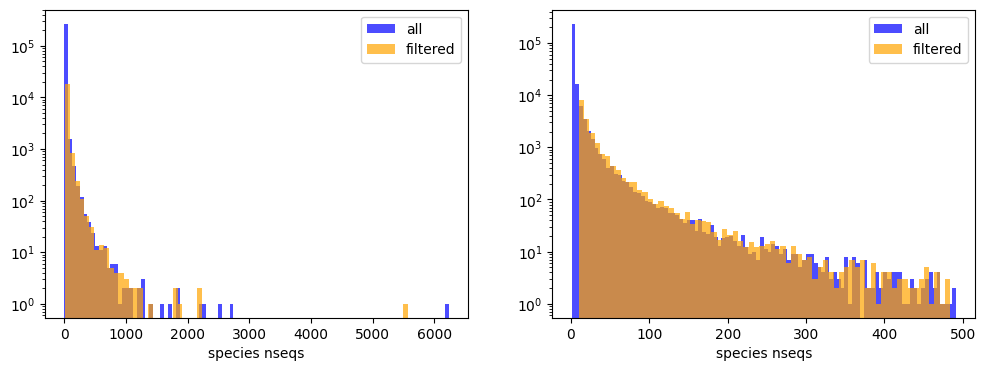

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([len(v) for v in seqs_arth.values()], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_arth_filtered.values()], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.subplot(122)
plt.hist([len(v) for v in seqs_arth.values() if len(v) < 500], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_arth_filtered.values() if len(v) < 500], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.show()

## Prepare dataset for CO1 alignment (outgrp selection)

In [20]:
arth_aln = collect_phylum_seqs(phylum, "LONGEST", ["CO1"])

100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


In [32]:
print(len(set([x.split("__")[1] for x in seqs_arth_filtered.keys()]).difference([x.split("__")[1] for x in arth_aln.keys()])), "species without CO1 seq")

136 species without CO1 seq


## Chordata

In [41]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Chordata"

In [42]:
seqs = defaultdict(list)
for gene in tqdm.tqdm(genes):
    inp = f"../data/MIDORI2/fasta/MIDORI2_UNIQ_NUC_GB253_{gene}_BLAST.fasta"
    for rec in SeqIO.parse(inp, "fasta"):
        header = rec.description
        
        if phylum not in header:
            continue

        raw_acc, taxa = header.split("###")
        acc, place = re.match("(\w+\.\d)\.(.+)", raw_acc).groups()
        taxa = taxa.removeprefix("root_1;Eukaryota_2759;")
        species = " ".join(taxa.split(";")[-1].split("_")[:-1])
        rec.id = acc
        rec.description = f"{species} {place} ###{taxa}"
        seqs[gene + "__" + species.replace(" ", "_")].append(rec)

100%|██████████| 13/13 [00:41<00:00,  3.20s/it]


In [43]:
nseqs_min = 10
var_gene_len = 0.2
seqs_filtered = dict()
for gene_species, recs in seqs.items():
    if len(recs) < nseqs_min:
        continue

    seq_len_mean = np.mean([len(x) for x in recs])
    recs_filtered = []
    for rec in recs:
        if seq_len_mean * (1 - var_gene_len) < len(rec) < seq_len_mean * (1 + var_gene_len):
            recs_filtered.append(rec)

    if len(recs_filtered) >= nseqs_min:
        seqs_filtered[gene_species] = recs_filtered

In [44]:
len(seqs_filtered)

14662

In [45]:
print(pd.Series(Counter([x.split("__")[0] for x in seqs_filtered.keys()])))

A6       501
A8       190
CO1     5138
CO2      207
CO3      204
Cytb    4497
ND1      384
ND2     1868
ND3      253
ND4      814
ND4L     121
ND5      285
ND6      200
dtype: int64


In [46]:
len(set([x.split("__")[1] for x in seqs_filtered.keys()]))

9818

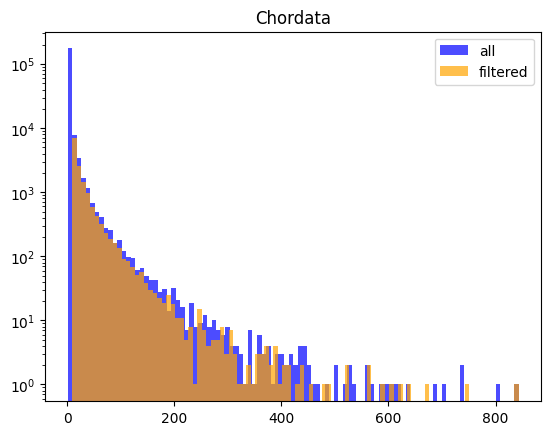

In [52]:
plt.hist([len(v) for v in seqs.values() if len(v) < 1000], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_filtered.values() if len(v) < 1000], bins=100, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
# plt.xscale("log")
plt.title(phylum)
plt.legend()
plt.show()